https://www.pythonf.cn/read/33854

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch import nn
import numpy as np
from torch.autograd import Variable
import torch

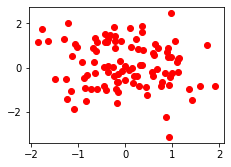

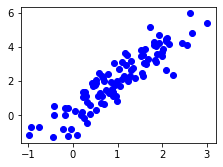

The covariance matrix is
[[1.01 1.95]
 [1.95 4.25]]


In [2]:
X=np.random.normal(size=(1000,2))
A=np.array([[1,2],[-0.1,0.5]])
b=np.array([1,2])
data=X.dot(A)+b

plt.figure(figsize=(3.5,2.5))
plt.scatter(X[:100,0],X[:100,1],color='red')
plt.show()
plt.figure(figsize=(3.5,2.5))
plt.scatter(data[:100,0],data[:100,1],color='blue')
plt.show()
print("The covariance matrix is\n%s" % np.dot(A.T, A))

batch_size=8
data_iter=DataLoader(data,batch_size=batch_size)

In [3]:
class net_G(nn.Module):
    def __init__(self):
        super(net_G,self).__init__()
        self.model=nn.Sequential(
            nn.Linear(2,2),
        )
        self._initialize_weights()
    def forward(self,x):
        x=self.model(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Linear):
                m.weight.data.normal_(0,0.02)
                m.bias.data.zero_()

In [4]:
class net_D(nn.Module):
    def __init__(self):
        super(net_D,self).__init__()
        self.model=nn.Sequential(
            nn.Linear(2,5),
            nn.Tanh(),
            nn.Linear(5,3),
            nn.Tanh(),
            nn.Linear(3,1),
            nn.Sigmoid()
        )
        self._initialize_weights()
    def forward(self,x):
        x=self.model(x)
        return x
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m,nn.Linear):
                m.weight.data.normal_(0,0.02)
                m.bias.data.zero_()

In [5]:
# Saved in the d2l package for later use
def update_D(X,Z,net_D,net_G,loss,trainer_D):
    batch_size=X.shape[0]
    Tensor=torch.FloatTensor
    ones=Variable(Tensor(np.ones(batch_size))).view(batch_size,1)
    zeros = Variable(Tensor(np.zeros(batch_size))).view(batch_size,1)
    real_Y=net_D(X.float())
    fake_X=net_G(Z)
    fake_Y=net_D(fake_X)
    loss_D=(loss(real_Y,ones)+loss(fake_Y,zeros))/2
    loss_D.backward()
    trainer_D.step()
    return float(loss_D.sum())

In [6]:
# Saved in the d2l package for later use
def update_G(Z,net_D,net_G,loss,trainer_G):
    batch_size=Z.shape[0]
    Tensor=torch.FloatTensor
    ones=Variable(Tensor(np.ones((batch_size,)))).view(batch_size,1)
    fake_X=net_G(Z)
    fake_Y=net_D(fake_X)
    loss_G=loss(fake_Y,ones)
    loss_G.backward()
    trainer_G.step()
    return float(loss_G.sum())

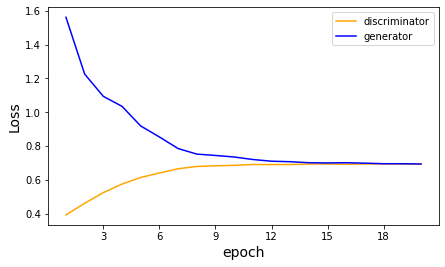

0.6936986446380615 0.6954083442687988


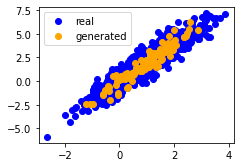

In [7]:
def train(net_D,net_G,data_iter,num_epochs,lr_D,lr_G,latent_dim,data):
    loss=nn.BCELoss()
    Tensor=torch.FloatTensor
    trainer_D=torch.optim.Adam(net_D.parameters(),lr=lr_D)
    trainer_G=torch.optim.Adam(net_G.parameters(),lr=lr_G)
    plt.figure(figsize=(7,4))
    d_loss_point=[]
    g_loss_point=[]
    d_loss=0
    g_loss=0
    for epoch in range(1,num_epochs+1):
        d_loss_sum=0
        g_loss_sum=0
        batch=0
        for X in data_iter:
            batch+=1
            X=Variable(X)
            batch_size=X.shape[0]
            Z=Variable(Tensor(np.random.normal(0,1,(batch_size,latent_dim))))
            trainer_D.zero_grad()
            d_loss = update_D(X, Z, net_D, net_G, loss, trainer_D)
            d_loss_sum+=d_loss
            trainer_G.zero_grad()
            g_loss = update_G(Z, net_D, net_G, loss, trainer_G)
            g_loss_sum+=g_loss
        d_loss_point.append(d_loss_sum/batch)
        g_loss_point.append(g_loss_sum/batch)
    plt.ylabel('Loss', fontdict={'size': 14})
    plt.xlabel('epoch', fontdict={'size': 14})
    plt.xticks(range(0,num_epochs+1,3))
    plt.plot(range(1,num_epochs+1),d_loss_point,color='orange',label='discriminator')
    plt.plot(range(1,num_epochs+1),g_loss_point,color='blue',label='generator')
    plt.legend()
    plt.show()
    print(d_loss,g_loss)
    
    Z =Variable(Tensor( np.random.normal(0, 1, size=(100, latent_dim))))
    fake_X=net_G(Z).detach().numpy()
    plt.figure(figsize=(3.5,2.5))
    plt.scatter(data[:,0],data[:,1],color='blue',label='real')
    plt.scatter(fake_X[:,0],fake_X[:,1],color='orange',label='generated')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    lr_D,lr_G,latent_dim,num_epochs=0.05,0.005,2,20
    generator=net_G()
    discriminator=net_D()
    train(discriminator,generator,data_iter,num_epochs,lr_D,lr_G,latent_dim,data)